In [1]:
import tensorflow as tf
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
import numpy as np 
from skimage.measure import compare_ssim
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import keras
import random
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from keras.utils import to_categorical
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras_ex.gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from math import log10, sqrt 
import cv2 
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

Using TensorFlow backend.


In [2]:
np.random.seed(1)
random.seed(1)

In [3]:
INDIVIDUALS = 50
MAX_GEN = 10000
P_CROSS = 0.6
P_MUTATION = 0.1
LEN = 784
MNIST_IMG = 28

In [4]:
def euclidean(s):
    # https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

def euc_fitness(individual, gt, pred, target, l1=0.5, l2=0.5, N = 50, n_classes=10):
    # petras fitness fucntion
    #print(l1*euclidean(individual-target)/N, l2*euclidean(pred-label)/n_classes)
    return -(l1*euclidean(individual-gt)/N + l2*euclidean(pred-target)/n_classes)

def computing_SSIM(individual,target):
    target = target.reshape(28,28)
    individual = individual.reshape(28,28)
    if individual.shape == target.shape:
        (score, diff) = compare_ssim(individual, target, full=True)
    else:
        print(target.shape)
        print(individual.shape)
    return score

def calculate_fitness(ind,target_image,label,l1=0.5, l2=0.5, N=50, num_classes=10):
    # predict the population
    predictions=model.predict(ind.reshape(1,28,28,1)) 
    # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
    predictions=predictions[0]
    po=predictions[label]
    # set that value to 0
    predictions[label]=0
    # take next highest one
    pd = np.max(predictions)
    diff = pd-po
    return l1*computing_SSIM(ind.reshape(28,28),target_image) + l2*(diff)

def pop_fitness(pop, target, predictions, label):
    return [calculate_fitness(p, target, pred, label) for p, pred in zip(pop, predictions)]

def flatten(imgs):
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, np.sqrt(0.01))

def p_noise(x):
    # add noise given probability
    if P_MUTATION > np.random.uniform():
          return x + gaussian_noise()
    else:
        return x

def add_noise(image):
    # define vectorized function to apply to image
    noise_v = np.vectorize(p_noise)
    return noise_v(image)

def k_crossover(im1, im2, k=2):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, 783, 1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, predictions, ground_truth, target, k=3):
    indices = np.random.choice(range(len(pop)), k, replace=False)
    individuals = pop.take(indices, axis=0)
    scores = [euc_fitness(ind, ground_truth, p, target) for ind ,p in zip(individuals, predictions)]
    index_max = np.argmax(scores) 
    winner = individuals[index_max]
    return winner

def check_adv_termination(ind, label,ground_truth, model):
    # individual - the best one from the generation
    # label - class we want
    # ground_truth - the image (28,28)
    # model we are using 
    dist = 1-compare_ssim(ind.reshape(MNIST_IMG,MNIST_IMG),ground_truth.reshape(MNIST_IMG,MNIST_IMG))
    predictions= model.predict(ind.reshape(1,MNIST_IMG,MNIST_IMG,1) / 255.0)
    predicted_label= np.argmax(predictions[0])
    if label != predicted_label and dist < 0.001:
        print("FOUND ADVERSARIAL")
        print(f"Fitness of the adversarial {calculate_fitness(model,ind,ground_truth,label)}")
        return individual
    return None 


def init_pop_from_sample(n, num, data, labels):
    indices = np.where(labels==num)[0]
    index = np.random.choice(indices, 1)
    sample = np.take(data, index, axis=0)
    x = np.array([add_noise(sample) for i in range(n)])
    return x.reshape(n, 784), sample

In [5]:
''' my part of the code ''' 
''' I know it is ugly, I will fix it . this is the intial version'''
# from Goorge Clooney paper
def quadrant_crossover(parent_1,parent_2):
    # reshape parents
    parent_1,parent_2= parent_1.reshape((MNIST_IMG,MNIST_IMG)), parent_2.reshape((MNIST_IMG,MNIST_IMG))
    # quadrants for both parents
    p1,p2,p3,p4,q1,q2,q3,q4 = [],[],[],[],[],[],[],[]
    child1, child2 = [],[]
    # getting random (x,y) point in 2D matrix
    x,y = np.random.randint(0,MNIST_IMG-1), np.random.randint(0,MNIST_IMG-1)  

    # choose which quadrant we want to crossover
    N = np.random.randint(0,3)
    #make quadrants
    for i in range(MNIST_IMG):
        if (i<=x):
            p1.append(parent_1[i][:y+1])
            p2.append(parent_1[i][y+1:])
            q1.append(parent_2[i][:y+1])
            q2.append(parent_2[i][y+1:])
        else:
            p3.append(parent_1[i][:y+1])
            p4.append(parent_1[i][y+1:])
            q3.append(parent_2[i][:y+1])
            q4.append(parent_2[i][y+1:])

    if (N==0):
        ch1 = connect_quadrants(p1,q2,q3,q4)
        ch2 = connect_quadrants(q1,p2,p3,p4)
    elif (N==1):
        ch1 = connect_quadrants(q1,p2,q3,q4)
        ch2 = connect_quadrants(p1,q2,p3,p4)
    elif (N==2):
        ch1 = connect_quadrants(q1,q2,p3,q4)
        ch2 = connect_quadrants(p1,p2,q3,p4)
    else:
        ch1 = connect_quadrants(q1,q2,q3,p4)
        ch2 = connect_quadrants(p1,p2,p3,q4)

    return ch1,ch2

def connect_quadrants(q1,q2,q3,q4):
    left = np.concatenate((q1,q3))
    right = np.concatenate((q2,q4))
    image = np.concatenate((left,right),axis=1)
    return image.flatten()


def multi_crossover(parent1,parent2,target):
    pop= []
    # 2-k crossover
    pop.append(k_crossover(parent1, parent2))
    # Gorge Clooney crossover
    pop.append(quadrant_crossover(parent1,parent2))
    # uniform crossover
    pop.append(k_crossover(parent1, parent2,1))
    # SSIM similarity 
    flattened_list = [y for x in pop for y in x] # need to flatten the list because pop is list of lists, cause every crossover function returns 2 obj
    ssim = [computing_SSIM(ind,target) for ind in flattened_list ]
    # taking the index of largest two score
    id1=np.argmax(ssim)
    ssim[id1]=0
    id2 = np.argmax(ssim)
    #returning parents
    return flattened_list[id1],flattened_list[id2]

In [6]:
def return_best_individual(sample_population,fitness):
    index = np.argmax(fitness)
    best = sample_population[index]
    return best

def choose_better_child(ch1, ch2,ground_truth,label,model):
    # I named it better child, but we choose by this parents as well
    ch1_f = calculate_fitness(model,ch1.reshape(MNIST_IMG,MNIST_IMG),ground_truth.reshape(MNIST_IMG,MNIST_IMG),label)
    ch2_f = calculate_fitness(model,ch2.reshape(MNIST_IMG,MNIST_IMG),ground_truth.reshape(MNIST_IMG,MNIST_IMG),label)
    # change this into ternary operator
    if ch1_f>ch2_f:
        return ch1
    else:
        return ch2

In [7]:
# load flatten and normalize mnist
#(x_train, y), (x_test, y_t) = tf.keras.datasets.mnist.load_data()
#X = flatten(x_train)
#X_test = flatten(x_test)
#X = np.array([x/255. for x in X])
#X_t = np.array([x/255. for x in X_test])
(X, y), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X = X.reshape((X.shape[0], -1))
X_sc = X / 255.0
X_sc.shape
y_cat = to_categorical(y)
X_test = X_test.reshape((X_test.shape[0], -1))
X_test_sc = X_test / 255.0

In [8]:
num_lm0 = 100
num_lm = num_lm0 * 10
init_list = []
for ii in range(10):
    init_wgt0 = X[y==ii]
    init_wgt0 = init_wgt0[np.random.choice(range(init_wgt0.shape[0]), size=num_lm0, replace=False)] + \
                np.random.normal(scale=0.01, size=num_lm0*784).reshape(num_lm0, 784)
    init_list.append(init_wgt0)
init_wgt = np.vstack(init_list)
init_wgt = init_wgt[np.random.permutation(range(init_wgt.shape[0]))]

inp2 = Input(shape=(28*28,), name='inp')
oup2 = GaussianKernel(num_lm, 28*28,
                     kernel_gamma='auto', weights=[init_wgt],
                     name='gkernel1')(inp2)
oup2 = Dense(10, activation='softmax')(oup2)
model = Model(inp2, oup2)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.load_weights("rbfnn_v2.h5")

In [9]:
'''
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
    original = []
    adversarial = []
    original_y = []
    adversarial_y = []
    for sample_class in range(num_classes):
        labels = y_test[(y_test==sample_class).reshape(num_samples)]
        samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
        samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
        samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
        for cluster in range(num_clusters):
            subsamples = np.where(kmeans==cluster)[0]
            ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
            original.extend(samples_orig[ori])
            original_y.extend(labels[ori])
            adversarial.extend(samples_orig[adv])
            adversarial_y.extend(labels[adv])
    return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

discard, subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_t,y_t,28,1,5,10,10000)
print('subsample_y.shape:', subsample_y.shape)
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(np.expand_dims(subsample_sc.reshape(subsample_sc.shape[0],28,28),axis=3))
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,28,1,5,10,1021)
print('original.shape:',original.shape)
print('adversarial.shape:', adversarial.shape)
print('adversarial.shape:', adversarial_y.shape)
'''
file_ = open('subset_rbf', 'rb')
original = pickle.load(file_)
adversarial = pickle.load(file_)
original_y = pickle.load(file_)
adversarial_y = pickle.load(file_)
file_.close()

In [10]:
def main(image, label):
    pop = tbx.population(n=INDIVIDUALS)


    # Evaluate the entire population
    fitnesses = list(map(tbx.evaluate, pop))
    
    # Set fitnesses to individuals
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
        
   # loop for the number of generation we need
    for g in range(MAX_GEN):
        
        preds = np.argmax(model.predict(np.array(pop).reshape((np.array(pop).shape[0],-1))/255.), axis=1)

        for ind, pred in zip(pop, preds):
            if pred != label:
                print(f'adverserial class {pred} for label {label} found in {g} generations!')
                return ind, g
            
        if g % 250 == 0:
            print(f'fitting gen: {g} with mean fitness value:', np.mean(fitnesses))
            
        # Select the next generation individuals
        offspring = tbx.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(tbx.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if np.random.uniform() < P_CROSS:
                
                tbx.mate(child1.reshape(784), child2.reshape(784))
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            tbx.mutate(mutant.reshape(784))
            del mutant.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(tbx.evaluate, invalid_ind))
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit


        pop[:] = offspring
    print('Max amount of generations reached')
    return return_best_individual(pop,fitnesses), g

fitting gen: 0 with mean fitness value: -0.4758548140525818
adverserial class 5 for label 0 found in 3 generations!
found [5] in 2.546875 seconds


C:\Users\Cyril de Kock\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  from ipykernel import kernelapp as app


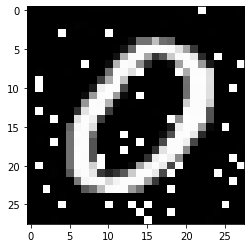

C:\Users\Cyril de Kock\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Cyril de Kock\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Cyril de Kock\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Strategy' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


fitting gen: 0 with mean fitness value: -0.4783497750759125
adverserial class 5 for label 0 found in 3 generations!
found [5] in 2.5625 seconds


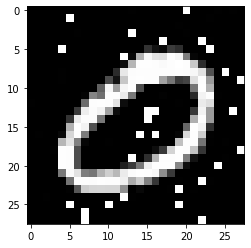

fitting gen: 0 with mean fitness value: -0.48808178305625916
adverserial class 5 for label 0 found in 4 generations!
found [5] in 3.203125 seconds


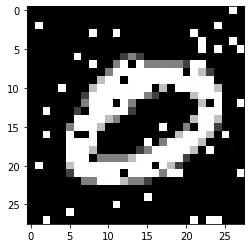

fitting gen: 0 with mean fitness value: -0.4913712441921234
adverserial class 5 for label 0 found in 3 generations!
found [5] in 2.453125 seconds


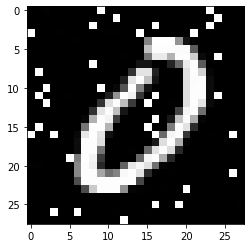

fitting gen: 0 with mean fitness value: -0.23119768500328064
adverserial class 5 for label 0 found in 1 generations!
found [5] in 1.078125 seconds


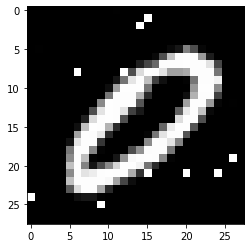

fitting gen: 0 with mean fitness value: -0.3003290295600891
adverserial class 5 for label 0 found in 1 generations!
found [5] in 1.265625 seconds


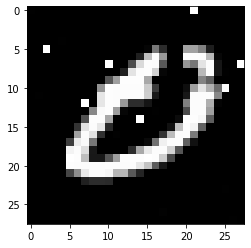

fitting gen: 0 with mean fitness value: -0.49668774008750916
adverserial class 5 for label 0 found in 8 generations!
found [5] in 5.890625 seconds


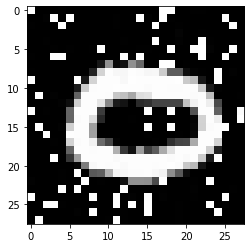

fitting gen: 0 with mean fitness value: -0.49841415882110596
adverserial class 5 for label 0 found in 4 generations!
found [5] in 3.1875 seconds


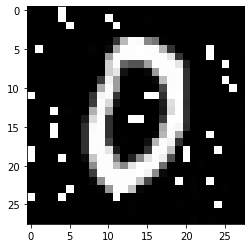

fitting gen: 0 with mean fitness value: -0.48151853680610657
adverserial class 5 for label 0 found in 3 generations!
found [5] in 2.46875 seconds


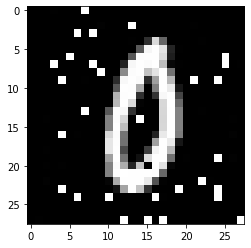

fitting gen: 0 with mean fitness value: -0.4985191524028778
adverserial class 5 for label 0 found in 4 generations!
found [5] in 3.203125 seconds


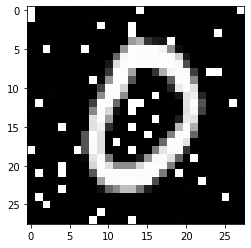

adverserial class 5 for label 0 found in 0 generations!
found [5] in 0.71875 seconds


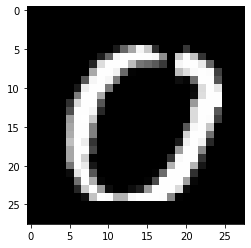

fitting gen: 0 with mean fitness value: -0.4970102906227112
adverserial class 5 for label 0 found in 6 generations!
found [5] in 4.6875 seconds


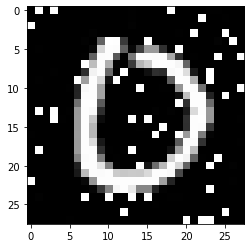

adverserial class 3 for label 0 found in 0 generations!
found [3] in 0.5 seconds


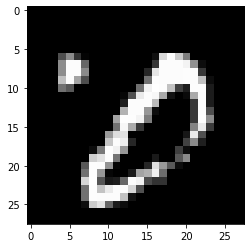

fitting gen: 0 with mean fitness value: -0.4955478608608246
adverserial class 5 for label 1 found in 3 generations!
found [5] in 2.859375 seconds


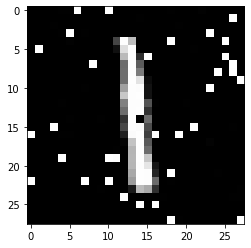

fitting gen: 0 with mean fitness value: -0.4990435540676117
adverserial class 3 for label 1 found in 4 generations!
found [3] in 3.234375 seconds


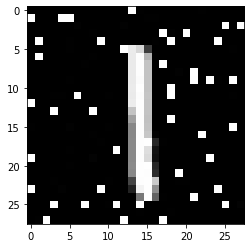

fitting gen: 0 with mean fitness value: -0.49092045426368713
adverserial class 3 for label 1 found in 2 generations!
found [3] in 1.921875 seconds


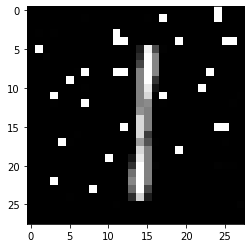

fitting gen: 0 with mean fitness value: -0.4998531639575958
adverserial class 3 for label 1 found in 5 generations!
found [3] in 4.078125 seconds


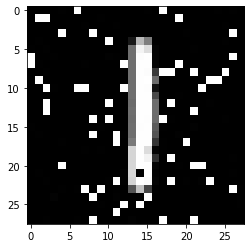

fitting gen: 0 with mean fitness value: -0.4902021586894989
adverserial class 8 for label 1 found in 4 generations!
found [2] in 3.46875 seconds


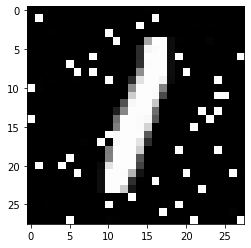

fitting gen: 0 with mean fitness value: -0.4744250178337097
adverserial class 8 for label 1 found in 1 generations!
found [1] in 1.203125 seconds


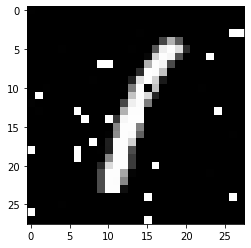

fitting gen: 0 with mean fitness value: -0.0332888662815094
adverserial class 7 for label 1 found in 1 generations!
found [7] in 1.359375 seconds


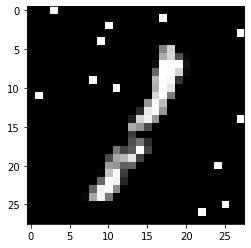

fitting gen: 0 with mean fitness value: -0.46272793412208557
adverserial class 5 for label 1 found in 2 generations!
found [5] in 1.8125 seconds


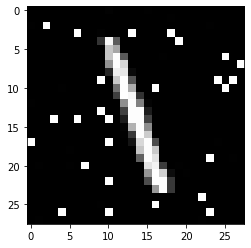

fitting gen: 0 with mean fitness value: -0.49656736850738525
adverserial class 5 for label 1 found in 3 generations!
found [5] in 2.8125 seconds


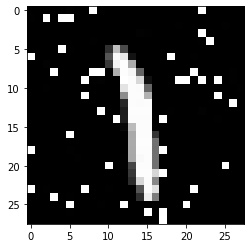

fitting gen: 0 with mean fitness value: -0.49949899315834045
adverserial class 5 for label 1 found in 4 generations!
found [5] in 3.21875 seconds


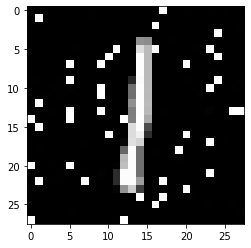

fitting gen: 0 with mean fitness value: -0.4991092383861542
adverserial class 3 for label 1 found in 6 generations!
found [3] in 4.34375 seconds


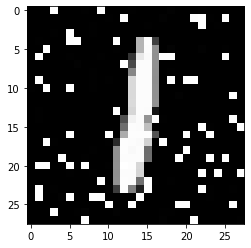

fitting gen: 0 with mean fitness value: -0.49897322058677673
adverserial class 2 for label 1 found in 3 generations!
found [2] in 2.703125 seconds


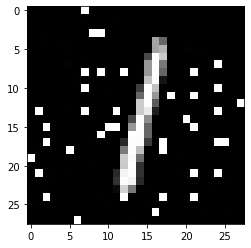

fitting gen: 0 with mean fitness value: -0.4987691342830658
adverserial class 3 for label 1 found in 6 generations!
found [3] in 4.15625 seconds


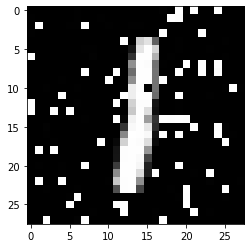

fitting gen: 0 with mean fitness value: -0.49130168557167053
adverserial class 2 for label 1 found in 3 generations!
found [2] in 2.34375 seconds


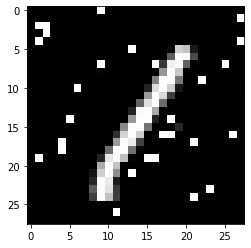

fitting gen: 0 with mean fitness value: -0.4989938735961914
adverserial class 2 for label 1 found in 5 generations!
found [2] in 3.75 seconds


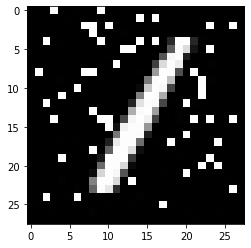

fitting gen: 0 with mean fitness value: -0.4990536868572235
adverserial class 5 for label 2 found in 13 generations!
found [5] in 9.59375 seconds


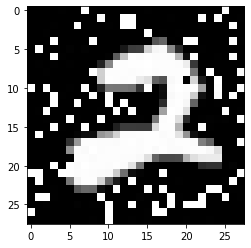

fitting gen: 0 with mean fitness value: -0.49488145112991333
adverserial class 3 for label 2 found in 9 generations!
found [3] in 6.8125 seconds


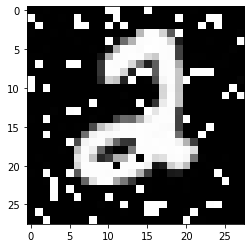

fitting gen: 0 with mean fitness value: -0.24276478588581085
adverserial class 6 for label 2 found in 2 generations!
found [6] in 2.046875 seconds


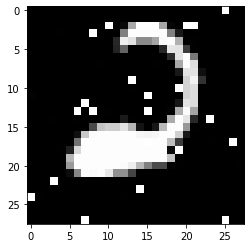

fitting gen: 0 with mean fitness value: -0.4537280201911926
adverserial class 3 for label 2 found in 6 generations!
found [5] in 4.546875 seconds


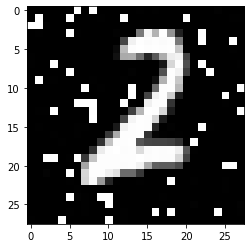

fitting gen: 0 with mean fitness value: -0.3935108184814453
adverserial class 5 for label 2 found in 1 generations!
found [5] in 1.3125 seconds


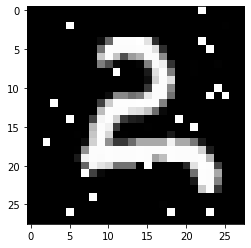

fitting gen: 0 with mean fitness value: -0.2424376755952835
adverserial class 8 for label 2 found in 1 generations!
found [8] in 1.328125 seconds


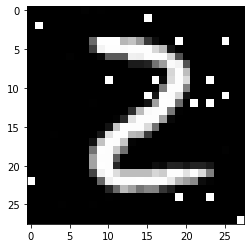

fitting gen: 0 with mean fitness value: -0.48163875937461853
adverserial class 5 for label 2 found in 7 generations!
found [5] in 5.609375 seconds


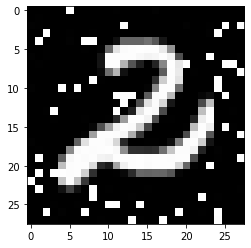

fitting gen: 0 with mean fitness value: -0.21494169533252716
adverserial class 3 for label 2 found in 4 generations!
found [3] in 3.203125 seconds


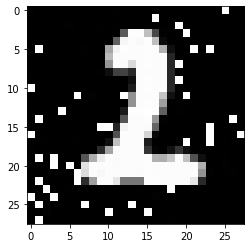

fitting gen: 0 with mean fitness value: -0.49521732330322266
adverserial class 3 for label 2 found in 6 generations!
found [3] in 4.921875 seconds


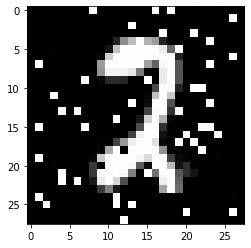

fitting gen: 0 with mean fitness value: -0.473941832780838
adverserial class 3 for label 2 found in 3 generations!
found [3] in 2.78125 seconds


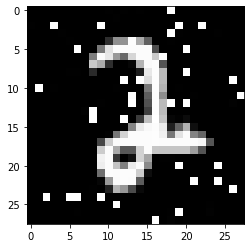

fitting gen: 0 with mean fitness value: -0.49335777759552
adverserial class 5 for label 2 found in 12 generations!
found [5] in 8.625 seconds


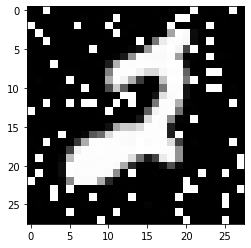

adverserial class 7 for label 2 found in 0 generations!
found [7] in 0.671875 seconds


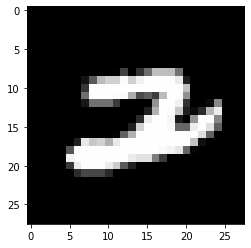

fitting gen: 0 with mean fitness value: -0.40238356590270996
adverserial class 5 for label 3 found in 1 generations!
found [5] in 1.265625 seconds


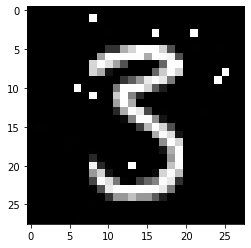

fitting gen: 0 with mean fitness value: -0.4984494745731354
adverserial class 5 for label 3 found in 5 generations!
found [5] in 3.890625 seconds


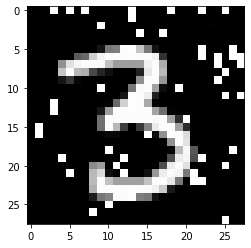

fitting gen: 0 with mean fitness value: -0.4972946047782898
adverserial class 5 for label 3 found in 9 generations!
found [3] in 6.578125 seconds


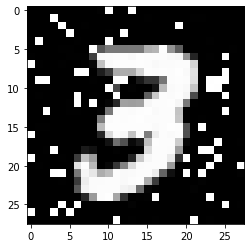

fitting gen: 0 with mean fitness value: -0.49666744470596313
adverserial class 5 for label 3 found in 7 generations!
found [5] in 5.296875 seconds


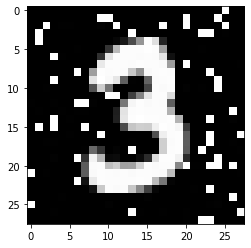

fitting gen: 0 with mean fitness value: -0.4969232976436615
adverserial class 5 for label 3 found in 6 generations!
found [5] in 4.75 seconds


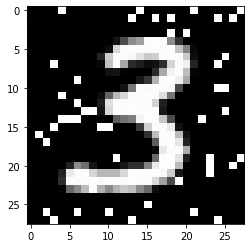

fitting gen: 0 with mean fitness value: -0.49594536423683167
adverserial class 5 for label 3 found in 5 generations!
found [5] in 3.78125 seconds


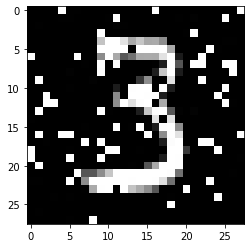

fitting gen: 0 with mean fitness value: -0.4997788965702057
adverserial class 5 for label 3 found in 9 generations!
found [5] in 6.65625 seconds


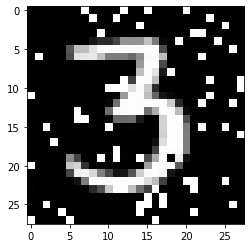

fitting gen: 0 with mean fitness value: -0.49910038709640503
adverserial class 5 for label 3 found in 6 generations!
found [5] in 4.578125 seconds


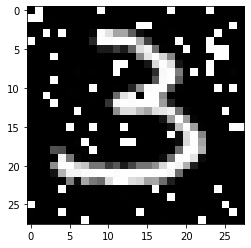

adverserial class 5 for label 3 found in 0 generations!
found [5] in 0.625 seconds


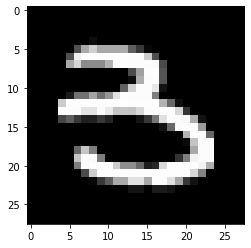

fitting gen: 0 with mean fitness value: -0.3304467797279358
adverserial class 8 for label 3 found in 2 generations!
found [3] in 2.15625 seconds


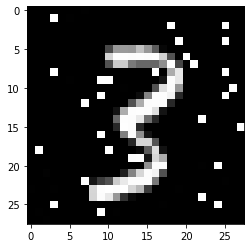

fitting gen: 0 with mean fitness value: -0.4954555332660675
adverserial class 5 for label 3 found in 6 generations!
found [5] in 4.421875 seconds


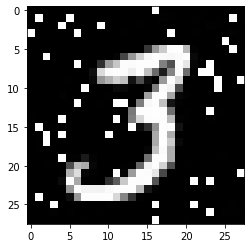

fitting gen: 0 with mean fitness value: -0.4974684417247772
adverserial class 5 for label 4 found in 6 generations!
found [5] in 4.328125 seconds


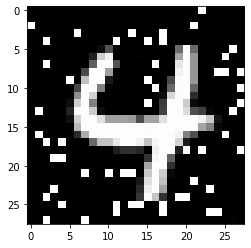

fitting gen: 0 with mean fitness value: -0.492867112159729
adverserial class 2 for label 4 found in 6 generations!
found [2] in 4.6875 seconds


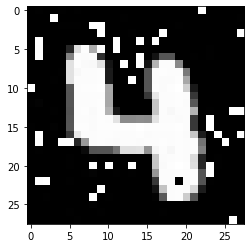

fitting gen: 0 with mean fitness value: -0.4910956919193268
adverserial class 9 for label 4 found in 5 generations!
found [9] in 3.34375 seconds


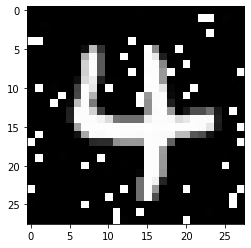

fitting gen: 0 with mean fitness value: -0.4978337585926056
adverserial class 5 for label 4 found in 3 generations!
found [5] in 2.71875 seconds


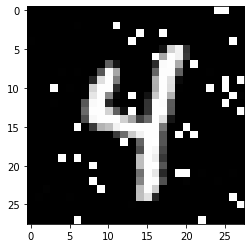

fitting gen: 0 with mean fitness value: -0.47085878252983093
adverserial class 9 for label 4 found in 2 generations!
found [9] in 2.03125 seconds


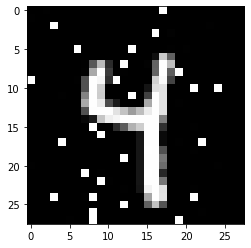

fitting gen: 0 with mean fitness value: -0.48345527052879333
adverserial class 8 for label 4 found in 3 generations!
found [8] in 2.109375 seconds


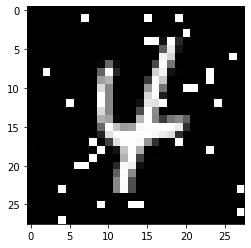

fitting gen: 0 with mean fitness value: -0.4920841455459595
adverserial class 7 for label 4 found in 4 generations!
found [7] in 3.046875 seconds


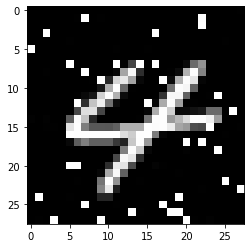

fitting gen: 0 with mean fitness value: -0.4992207884788513
adverserial class 5 for label 4 found in 4 generations!
found [5] in 3.1875 seconds


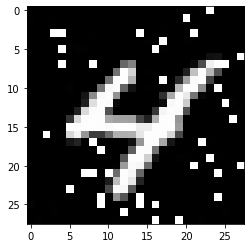

fitting gen: 0 with mean fitness value: -0.4891526401042938
adverserial class 9 for label 4 found in 2 generations!
found [9] in 1.828125 seconds


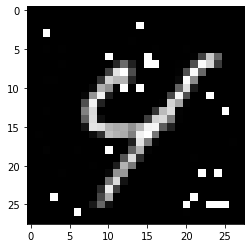

fitting gen: 0 with mean fitness value: -0.4965750277042389
adverserial class 9 for label 4 found in 4 generations!
found [9] in 2.90625 seconds


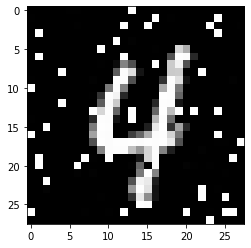

fitting gen: 0 with mean fitness value: -0.4732370972633362
adverserial class 9 for label 4 found in 2 generations!
found [9] in 1.890625 seconds


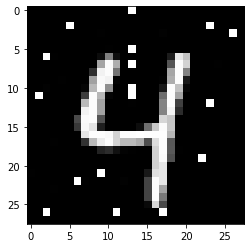

fitting gen: 0 with mean fitness value: -0.4944327771663666
adverserial class 5 for label 4 found in 3 generations!
found [4] in 2.515625 seconds


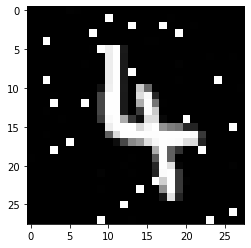

fitting gen: 0 with mean fitness value: -0.46533727645874023
adverserial class 9 for label 4 found in 2 generations!
found [9] in 1.578125 seconds


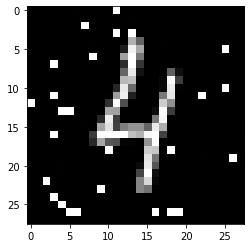

fitting gen: 0 with mean fitness value: -0.45777690410614014
adverserial class 2 for label 5 found in 35 generations!
found [5] in 23.515625 seconds


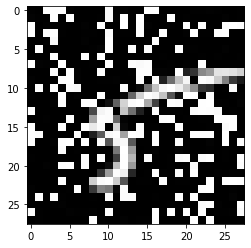

fitting gen: 0 with mean fitness value: -0.42417898774147034
adverserial class 7 for label 5 found in 5 generations!
found [5] in 3.8125 seconds


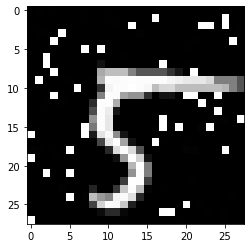

fitting gen: 0 with mean fitness value: -0.4853144884109497
adverserial class 2 for label 5 found in 50 generations!
found [2] in 32.015625 seconds


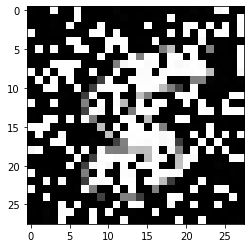

fitting gen: 0 with mean fitness value: -0.49645987153053284
adverserial class 3 for label 5 found in 139 generations!
found [5] in 89.71875 seconds


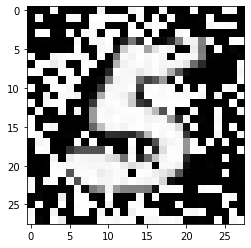

fitting gen: 0 with mean fitness value: -0.4948756694793701
fitting gen: 250 with mean fitness value: -3.469215425767224
adverserial class 3 for label 5 found in 260 generations!
found [3] in 166.3125 seconds


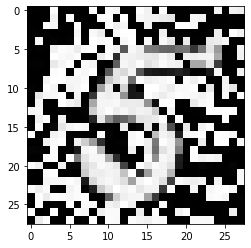

fitting gen: 0 with mean fitness value: -0.43371954560279846
adverserial class 2 for label 5 found in 7 generations!
found [2] in 5.171875 seconds


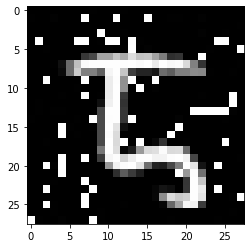

adverserial class 8 for label 5 found in 0 generations!
found [8] in 0.5625 seconds


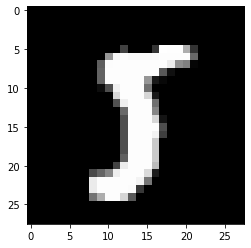

adverserial class 8 for label 5 found in 0 generations!
found [8] in 0.609375 seconds


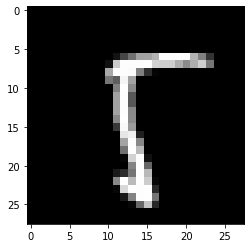

fitting gen: 0 with mean fitness value: -0.3899417221546173
adverserial class 3 for label 5 found in 3 generations!
found [5] in 2.578125 seconds


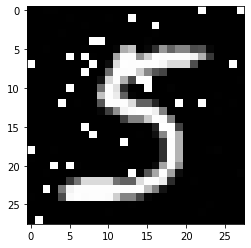

fitting gen: 0 with mean fitness value: -0.26710012555122375
adverserial class 3 for label 5 found in 4 generations!
found [3] in 3.3125 seconds


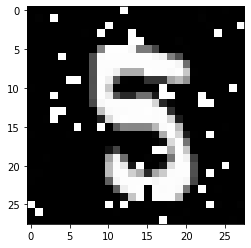

adverserial class 3 for label 5 found in 0 generations!
found [3] in 0.59375 seconds


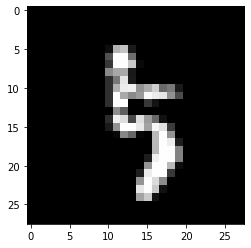

fitting gen: 0 with mean fitness value: -0.42587849497795105
adverserial class 3 for label 5 found in 20 generations!
found [5] in 13.15625 seconds


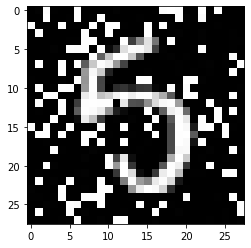

adverserial class 0 for label 6 found in 0 generations!
found [0] in 0.59375 seconds


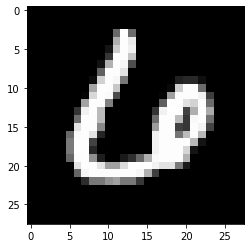

fitting gen: 0 with mean fitness value: -0.4690837562084198
adverserial class 2 for label 6 found in 2 generations!
found [2] in 1.578125 seconds


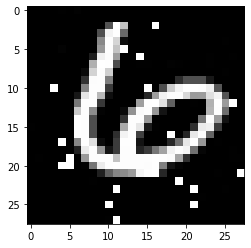

fitting gen: 0 with mean fitness value: -0.4987931251525879
adverserial class 5 for label 6 found in 3 generations!
found [5] in 2.40625 seconds


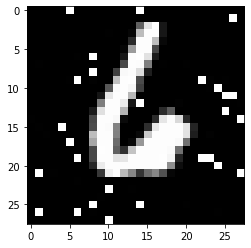

fitting gen: 0 with mean fitness value: -0.47569698095321655
adverserial class 2 for label 6 found in 3 generations!
found [2] in 2.484375 seconds


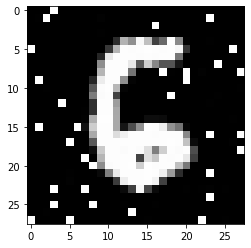

fitting gen: 0 with mean fitness value: -0.4870550036430359
adverserial class 2 for label 6 found in 3 generations!
found [2] in 2.390625 seconds


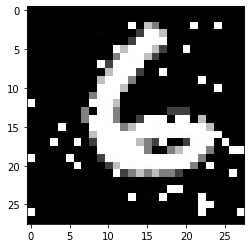

fitting gen: 0 with mean fitness value: -0.48514240980148315
adverserial class 2 for label 6 found in 5 generations!
found [2] in 4.34375 seconds


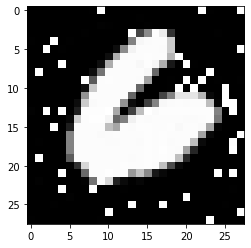

fitting gen: 0 with mean fitness value: -0.3276875913143158
adverserial class 5 for label 6 found in 1 generations!
found [5] in 1.375 seconds


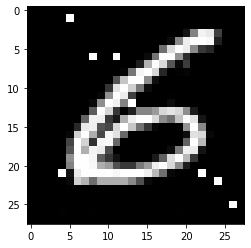

fitting gen: 0 with mean fitness value: -0.47850099205970764
adverserial class 5 for label 6 found in 2 generations!
found [5] in 1.828125 seconds


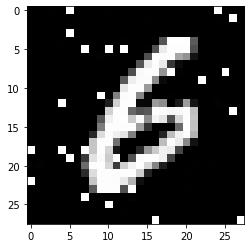

fitting gen: 0 with mean fitness value: -0.499246746301651
adverserial class 2 for label 6 found in 5 generations!
found [2] in 3.984375 seconds


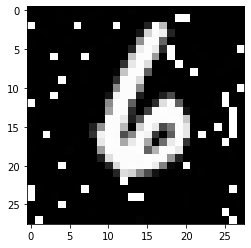

fitting gen: 0 with mean fitness value: -0.22968998551368713
adverserial class 5 for label 6 found in 1 generations!
found [5] in 1.375 seconds


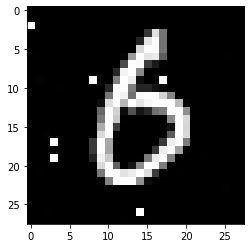

fitting gen: 0 with mean fitness value: -0.4952946901321411
adverserial class 5 for label 6 found in 3 generations!
found [5] in 2.625 seconds


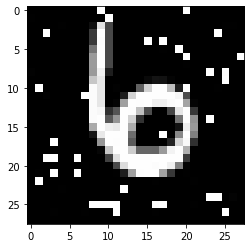

fitting gen: 0 with mean fitness value: -0.4865417778491974
adverserial class 5 for label 6 found in 2 generations!
found [5] in 1.953125 seconds


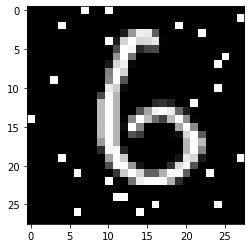

adverserial class 4 for label 7 found in 0 generations!
found [4] in 0.59375 seconds


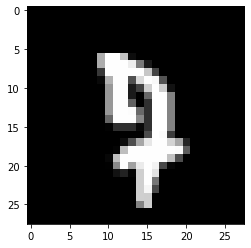

fitting gen: 0 with mean fitness value: -0.11957478523254395
adverserial class 2 for label 7 found in 1 generations!
found [2] in 1.265625 seconds


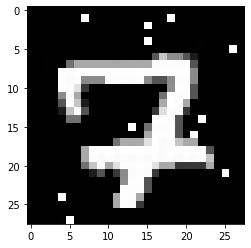

fitting gen: 0 with mean fitness value: -0.4911189079284668
adverserial class 3 for label 7 found in 3 generations!
found [3] in 3.046875 seconds


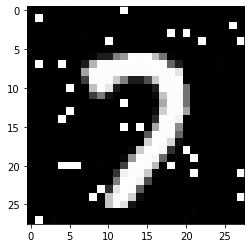

fitting gen: 0 with mean fitness value: -0.49813875555992126
adverserial class 5 for label 7 found in 5 generations!
found [5] in 4.046875 seconds


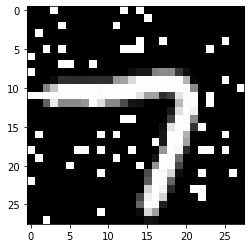

fitting gen: 0 with mean fitness value: -0.4985423684120178
adverserial class 3 for label 7 found in 6 generations!
found [3] in 4.609375 seconds


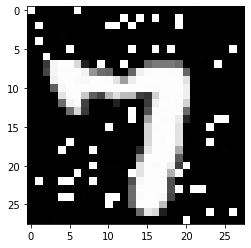

adverserial class 1 for label 7 found in 0 generations!
found [1] in 0.6875 seconds


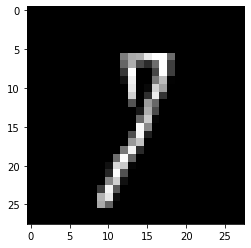

fitting gen: 0 with mean fitness value: -0.38019272685050964
adverserial class 2 for label 7 found in 1 generations!
found [2] in 1.28125 seconds


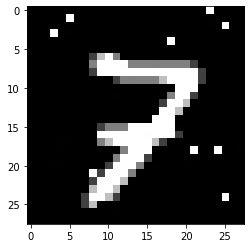

fitting gen: 0 with mean fitness value: -0.47016483545303345
adverserial class 9 for label 7 found in 4 generations!
found [9] in 3.1875 seconds


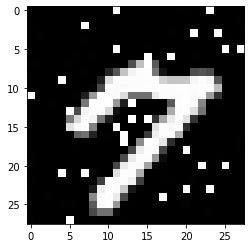

fitting gen: 0 with mean fitness value: -0.49887245893478394
adverserial class 2 for label 7 found in 6 generations!
found [2] in 5.015625 seconds


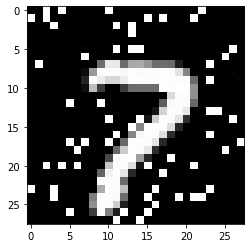

fitting gen: 0 with mean fitness value: -0.4965065121650696
adverserial class 3 for label 7 found in 6 generations!
found [3] in 4.46875 seconds


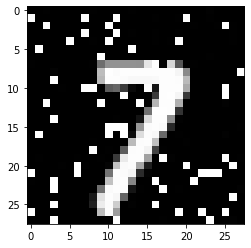

fitting gen: 0 with mean fitness value: -0.4870878756046295
adverserial class 3 for label 7 found in 2 generations!
found [3] in 1.96875 seconds


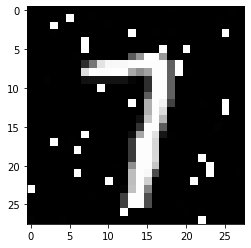

fitting gen: 0 with mean fitness value: -0.4985290467739105
adverserial class 3 for label 7 found in 5 generations!
found [3] in 4.21875 seconds


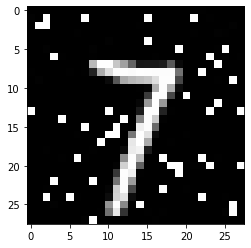

fitting gen: 0 with mean fitness value: -0.4900602400302887
adverserial class 3 for label 7 found in 2 generations!
found [3] in 1.921875 seconds


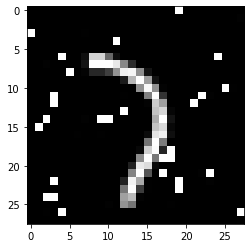

fitting gen: 0 with mean fitness value: -0.4957326054573059
adverserial class 5 for label 8 found in 4 generations!
found [5] in 3.375 seconds


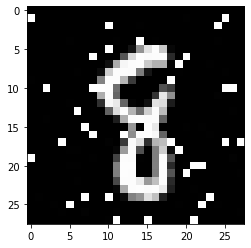

fitting gen: 0 with mean fitness value: -0.4965328574180603
adverserial class 3 for label 8 found in 3 generations!
found [3] in 2.703125 seconds


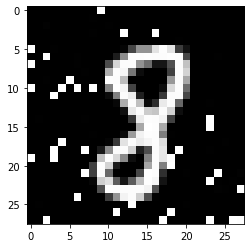

fitting gen: 0 with mean fitness value: -0.4967918395996094
adverserial class 3 for label 8 found in 5 generations!
found [8] in 4.015625 seconds


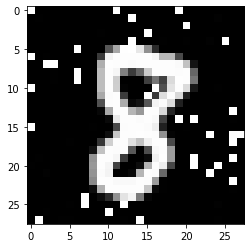

fitting gen: 0 with mean fitness value: -0.49777281284332275
adverserial class 5 for label 8 found in 4 generations!
found [8] in 3.15625 seconds


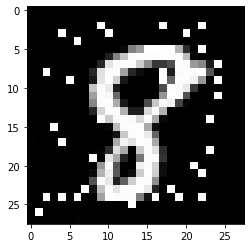

fitting gen: 0 with mean fitness value: -0.48728328943252563
adverserial class 2 for label 8 found in 3 generations!
found [2] in 2.78125 seconds


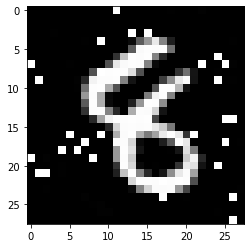

fitting gen: 0 with mean fitness value: -0.47600165009498596
adverserial class 3 for label 8 found in 2 generations!
found [3] in 1.96875 seconds


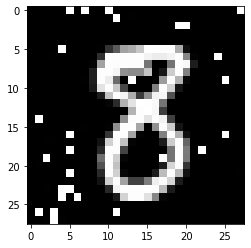

fitting gen: 0 with mean fitness value: -0.48537084460258484
adverserial class 3 for label 8 found in 3 generations!
found [3] in 2.734375 seconds


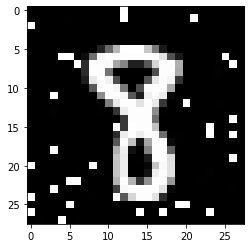

fitting gen: 0 with mean fitness value: -0.4740394949913025
adverserial class 2 for label 8 found in 3 generations!
found [2] in 2.203125 seconds


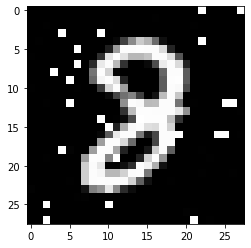

fitting gen: 0 with mean fitness value: -0.3844030499458313
adverserial class 5 for label 8 found in 1 generations!
found [5] in 1.3125 seconds


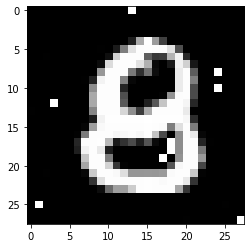

fitting gen: 0 with mean fitness value: -0.49908071756362915
adverserial class 5 for label 8 found in 7 generations!
found [5] in 5.296875 seconds


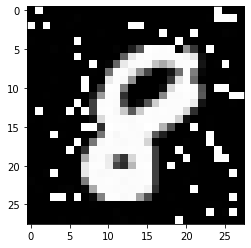

fitting gen: 0 with mean fitness value: -0.4830400347709656
adverserial class 5 for label 8 found in 3 generations!
found [5] in 2.828125 seconds


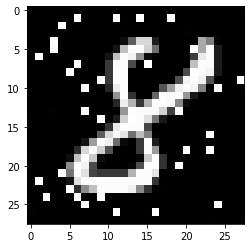

fitting gen: 0 with mean fitness value: -0.4962787926197052
adverserial class 5 for label 8 found in 4 generations!
found [5] in 3.328125 seconds


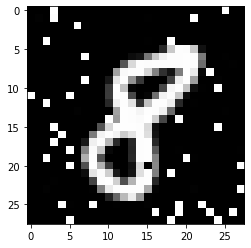

fitting gen: 0 with mean fitness value: -0.34889692068099976
adverserial class 4 for label 9 found in 3 generations!
found [4] in 2.578125 seconds


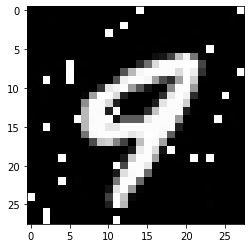

fitting gen: 0 with mean fitness value: -0.4944477081298828
adverserial class 5 for label 9 found in 10 generations!
found [9] in 7.28125 seconds


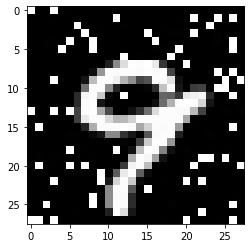

fitting gen: 0 with mean fitness value: -0.3293960690498352
adverserial class 5 for label 9 found in 2 generations!
found [5] in 1.96875 seconds


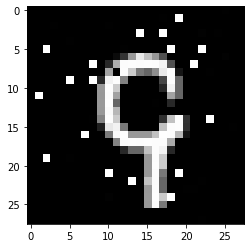

fitting gen: 0 with mean fitness value: -0.4501015245914459
adverserial class 8 for label 9 found in 5 generations!
found [8] in 4.15625 seconds


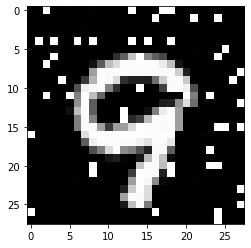

fitting gen: 0 with mean fitness value: -0.46180054545402527
adverserial class 5 for label 9 found in 8 generations!
found [5] in 5.890625 seconds


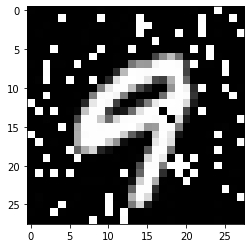

fitting gen: 0 with mean fitness value: -0.47393953800201416
adverserial class 3 for label 9 found in 5 generations!
found [3] in 3.859375 seconds


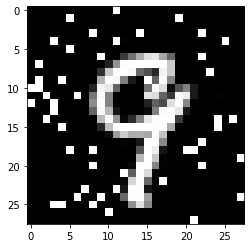

fitting gen: 0 with mean fitness value: -0.42501112818717957
adverserial class 5 for label 9 found in 3 generations!
found [5] in 2.390625 seconds


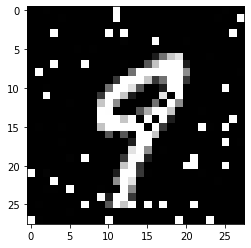

fitting gen: 0 with mean fitness value: -0.02660277485847473
adverserial class 4 for label 9 found in 1 generations!
found [4] in 1.171875 seconds


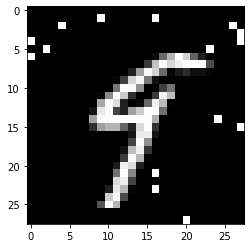

fitting gen: 0 with mean fitness value: -0.4970126450061798
adverserial class 5 for label 9 found in 9 generations!
found [5] in 6.875 seconds


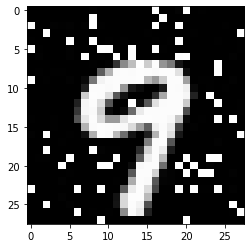

fitting gen: 0 with mean fitness value: -0.4486220180988312
adverserial class 3 for label 9 found in 2 generations!
found [3] in 2.015625 seconds


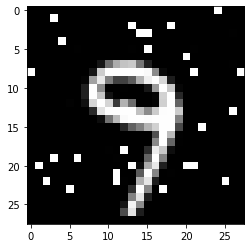

fitting gen: 0 with mean fitness value: -0.10007934272289276
adverserial class 5 for label 9 found in 1 generations!
found [5] in 1.125 seconds


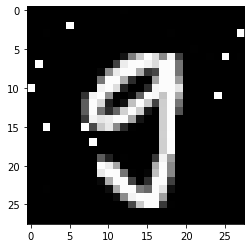

fitting gen: 0 with mean fitness value: -0.46459704637527466
adverserial class 2 for label 9 found in 4 generations!
found [5] in 3.78125 seconds


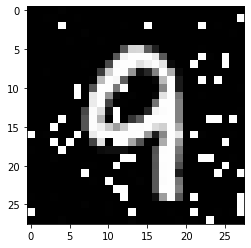

fitting gen: 0 with mean fitness value: -0.4205611050128937
adverserial class 7 for label 9 found in 7 generations!
found [7] in 5.421875 seconds


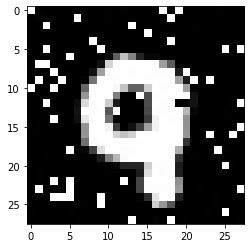

In [11]:
times = []
nfes = []
psnrs = []
predicted_classes = []
adversarials = []
ssim_scores = []

for i, (im, lbl) in enumerate(zip(adversarial, adversarial_y)):
    start = time.process_time()
    CURRENT_IM  = im
    CURRENT_LABEL = lbl
    
    def gen_ind():
        return adversarial[i]
    
    def calculate_fitness(ind, l1=0.5, l2=0.5): 
        # this is indredibly stupid but had do be done to combine our setup wit DEAP...
        
        target_image = CURRENT_IM
        label = CURRENT_LABEL
        predictions = model.predict(ind.reshape((ind.shape[0],-1))/255.)

        # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
        predictions = predictions[0]
        po = predictions[label]

        # set that value to 0
        predictions[label]=0

        # take next highest one
        pd = np.max(predictions)
        diff=pd-po
        a = l1*euclidean(ind-target_image)/LEN
        return (-a+l2*(diff)),
    
    # encode strategy
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", np.ndarray, typecode="d", fitness=creator.FitnessMax, strategy=None)
    creator.create("Strategy", np.ndarray, typecode="d")


    # create population
    tbx = base.Toolbox()
    tbx.register("individual", 
                 tools.initRepeat, 
                 creator.Individual,
                 gen_ind,
                 n=1)
    tbx.register("population", tools.initRepeat, list, tbx.individual)

# parameters
    tbx.register("evaluate", calculate_fitness)
    tbx.register("mate", tools.cxUniform, indpb=P_CROSS) #tools.cxTwoPoint, tools.cxUniform
    tbx.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=P_MUTATION)
    tbx.register("select", tools.selTournament, tournsize=3)
    
    example, generations = main(im, lbl)
    
    adversarials.append(example)
    nfes.append(generations)
    predicted_classes.append(model.predict(example.reshape((example.shape[0],-1))/255.))
    ssim_scores.append(computing_SSIM(example, CURRENT_IM))
    psnrs.append(cv2.PSNR(CURRENT_IM.reshape(28,28), example.reshape(28,28)))
    times.append(time.process_time() - start)
    
    print(f'found {np.argmax(model.predict(example.reshape((example.shape[0],-1))/255.), axis=1)} in {time.process_time() - start} seconds')
    plt.imshow(example.reshape(28,28), cmap="gray")
    plt.show()

In [12]:
file_ = open('adv_rbf_1_un', 'wb')
adversarials = [np.array(x) for x in adversarials]
pickle.dump(adversarials, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(ssim_scores, file_)
pickle.dump(predicted_classes, file_)
file_.close()

PSNR for image 0: 361.20199909921956


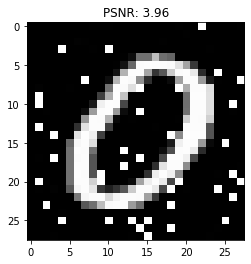

PSNR for image 1: 361.20199909921956


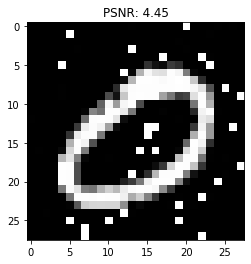

PSNR for image 2: 361.20199909921956


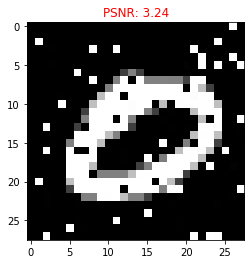

PSNR for image 3: 361.20199909921956


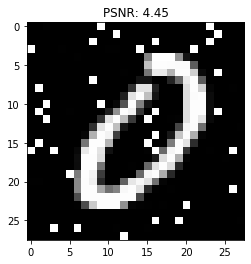

PSNR for image 4: 361.20199909921956


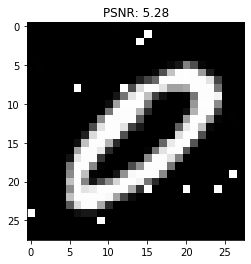

PSNR for image 5: 361.20199909921956


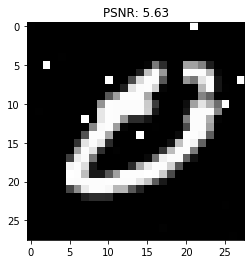

PSNR for image 6: 361.20199909921956


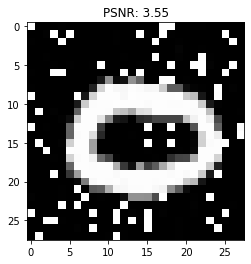

PSNR for image 7: 361.20199909921956


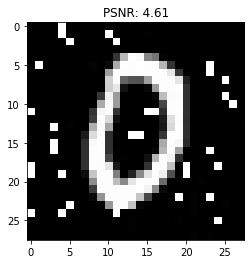

PSNR for image 8: 361.20199909921956


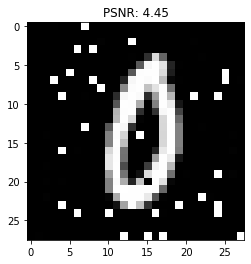

PSNR for image 9: 361.20199909921956


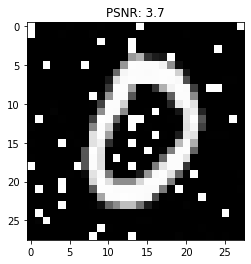

PSNR for image 10: 361.20199909921956


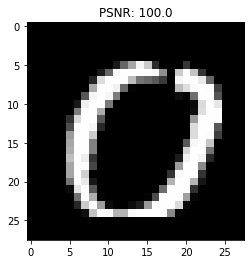

PSNR for image 11: 361.20199909921956


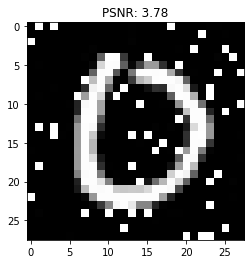

PSNR for image 12: 361.20199909921956


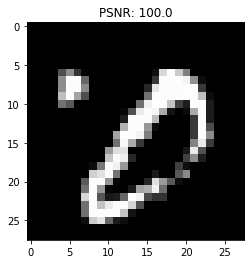

PSNR for image 13: 361.20199909921956


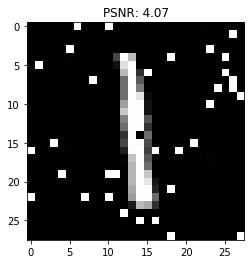

PSNR for image 14: 361.20199909921956


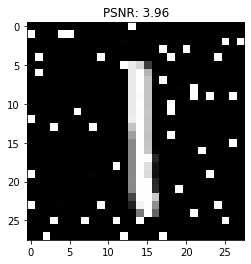

PSNR for image 15: 361.20199909921956


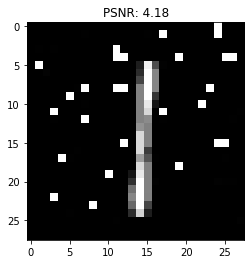

PSNR for image 16: 361.20199909921956


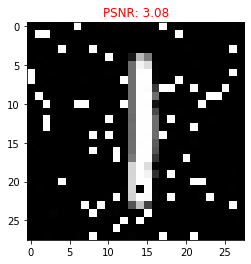

PSNR for image 17: 361.20199909921956


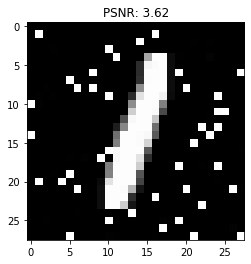

PSNR for image 18: 361.20199909921956


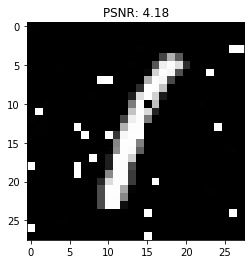

PSNR for image 19: 361.20199909921956


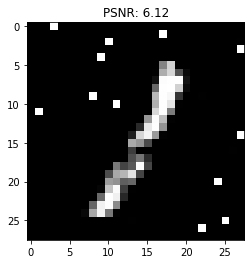

PSNR for image 20: 361.20199909921956


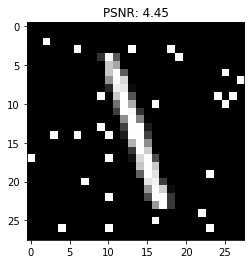

PSNR for image 21: 361.20199909921956


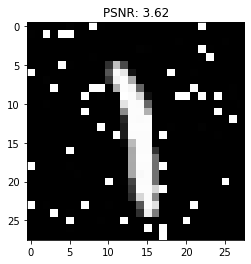

PSNR for image 22: 361.20199909921956


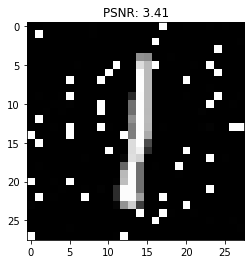

PSNR for image 23: 361.20199909921956


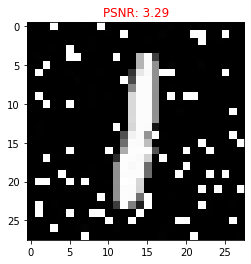

PSNR for image 24: 361.20199909921956


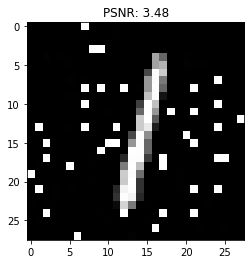

PSNR for image 25: 361.20199909921956


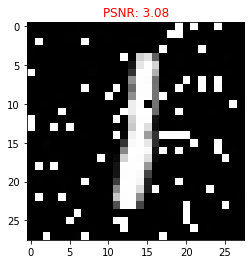

PSNR for image 26: 361.20199909921956


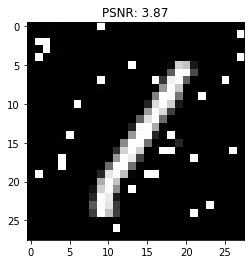

PSNR for image 27: 361.20199909921956


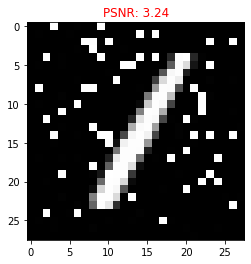

PSNR for image 28: 361.20199909921956


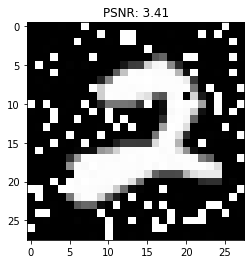

PSNR for image 29: 361.20199909921956


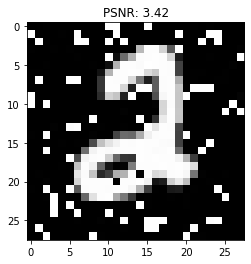

PSNR for image 30: 361.20199909921956


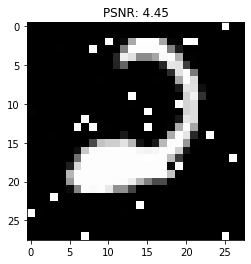

PSNR for image 31: 361.20199909921956


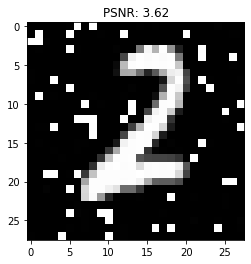

PSNR for image 32: 361.20199909921956


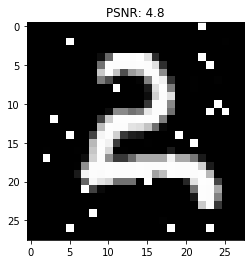

PSNR for image 33: 361.20199909921956


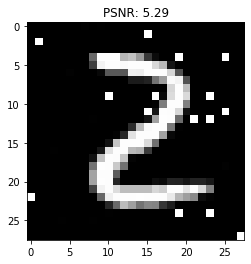

PSNR for image 34: 361.20199909921956


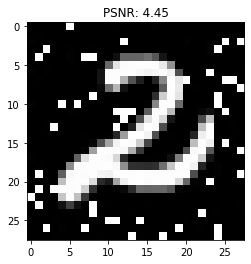

PSNR for image 35: 361.20199909921956


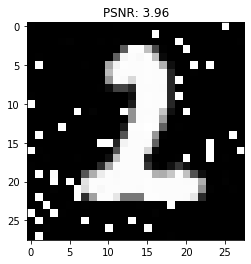

PSNR for image 36: 361.20199909921956


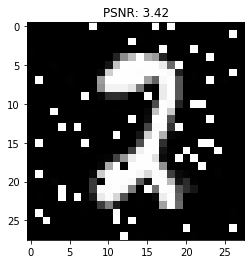

PSNR for image 37: 361.20199909921956


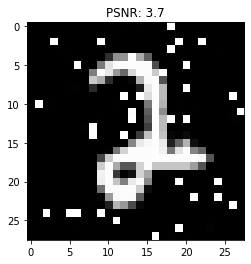

PSNR for image 38: 361.20199909921956


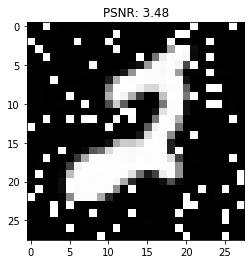

PSNR for image 39: 361.20199909921956


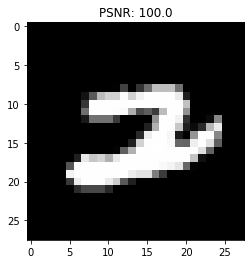

PSNR for image 40: 361.20199909921956


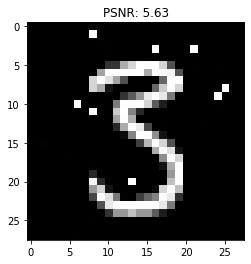

PSNR for image 41: 361.20199909921956


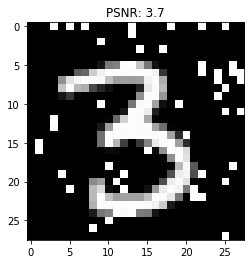

PSNR for image 42: 361.20199909921956


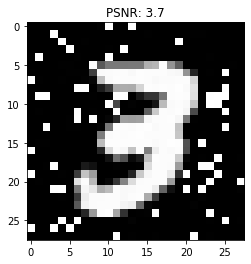

PSNR for image 43: 361.20199909921956


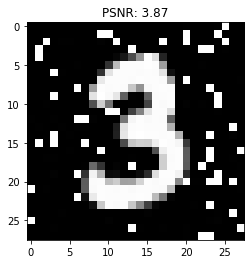

PSNR for image 44: 361.20199909921956


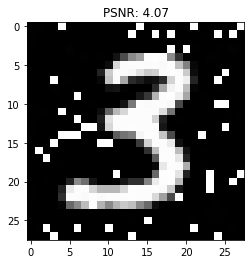

PSNR for image 45: 361.20199909921956


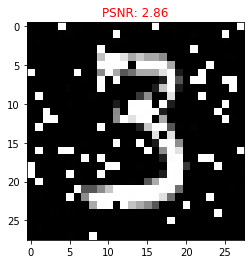

PSNR for image 46: 361.20199909921956


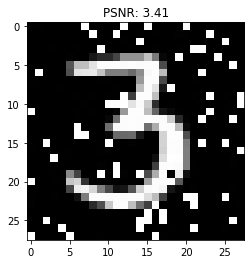

PSNR for image 47: 361.20199909921956


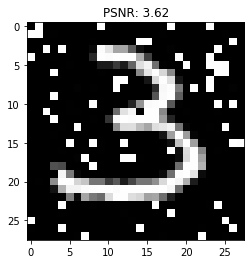

PSNR for image 48: 361.20199909921956


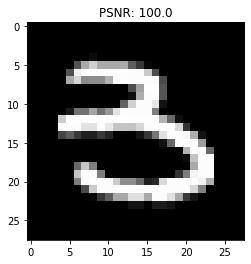

PSNR for image 49: 361.20199909921956


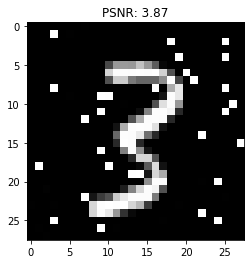

PSNR for image 50: 361.20199909921956


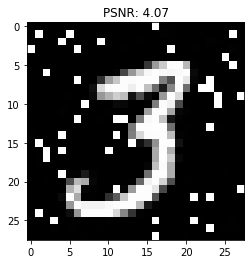

PSNR for image 51: 361.20199909921956


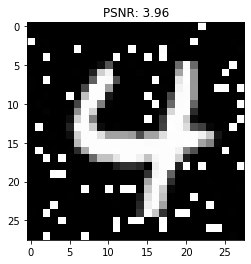

PSNR for image 52: 361.20199909921956


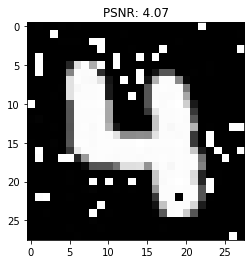

PSNR for image 53: 361.20199909921956


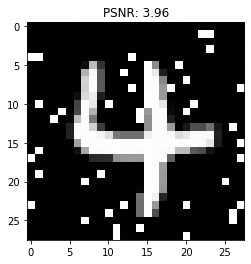

PSNR for image 54: 361.20199909921956


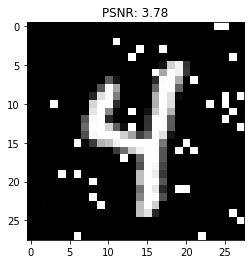

PSNR for image 55: 361.20199909921956


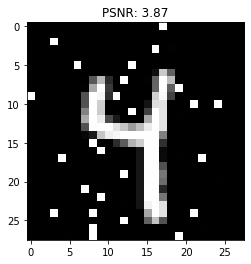

PSNR for image 56: 361.20199909921956


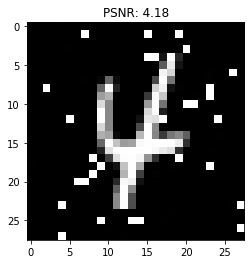

PSNR for image 57: 361.20199909921956


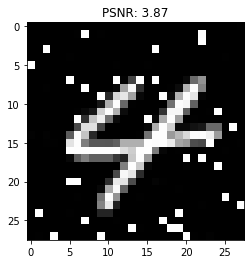

PSNR for image 58: 361.20199909921956


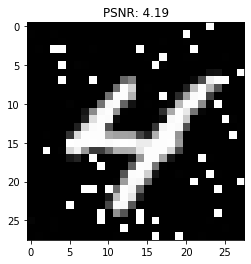

PSNR for image 59: 361.20199909921956


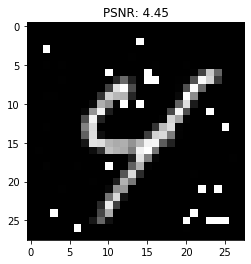

PSNR for image 60: 361.20199909921956


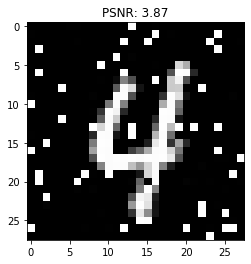

PSNR for image 61: 361.20199909921956


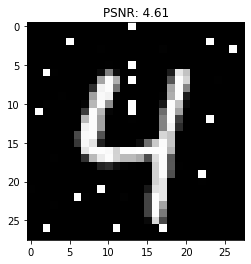

PSNR for image 62: 361.20199909921956


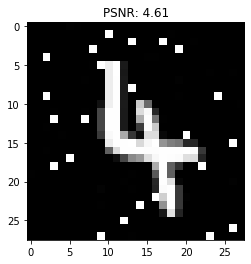

PSNR for image 63: 361.20199909921956


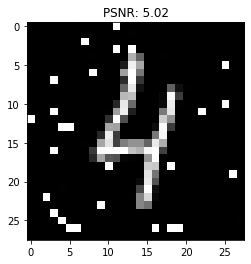

PSNR for image 64: 361.20199909921956


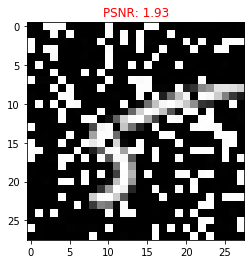

PSNR for image 65: 361.20199909921956


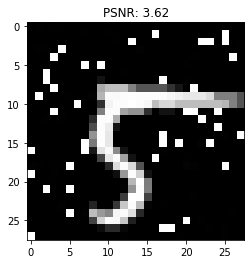

PSNR for image 66: 361.20199909921956


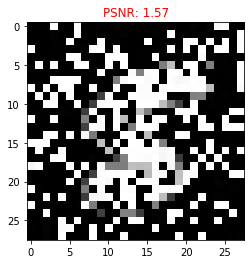

PSNR for image 67: 361.20199909921956


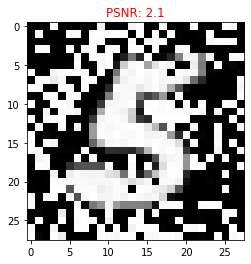

PSNR for image 68: 361.20199909921956


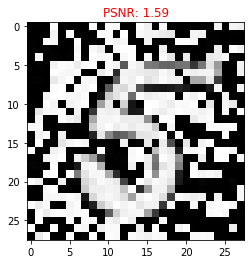

PSNR for image 69: 361.20199909921956


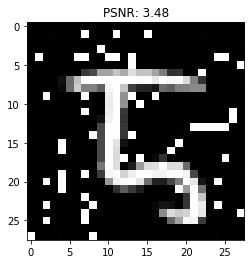

PSNR for image 70: 361.20199909921956


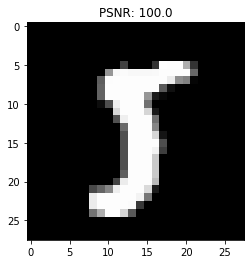

PSNR for image 71: 361.20199909921956


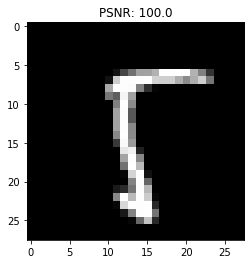

PSNR for image 72: 361.20199909921956


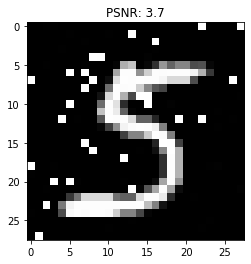

PSNR for image 73: 361.20199909921956


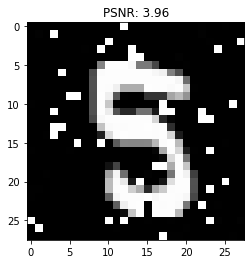

PSNR for image 74: 361.20199909921956


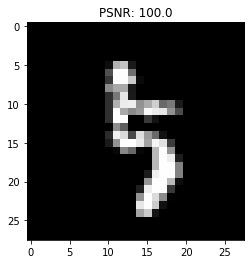

PSNR for image 75: 361.20199909921956


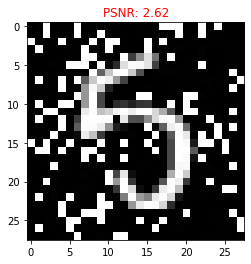

PSNR for image 76: 361.20199909921956


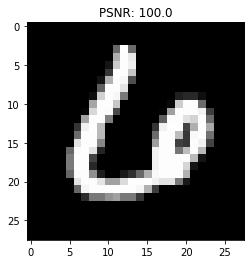

PSNR for image 77: 361.20199909921956


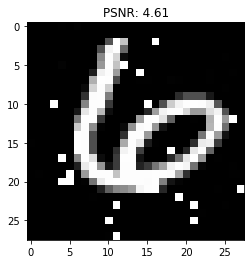

PSNR for image 78: 361.20199909921956


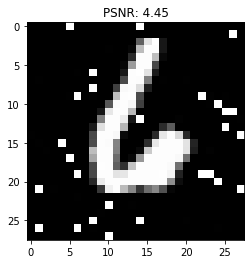

PSNR for image 79: 361.20199909921956


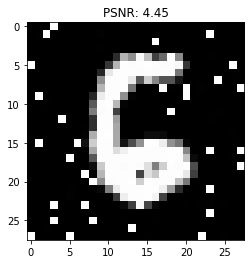

PSNR for image 80: 361.20199909921956


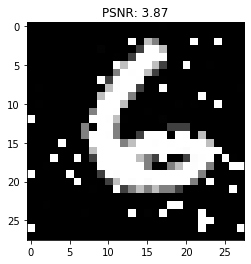

PSNR for image 81: 361.20199909921956


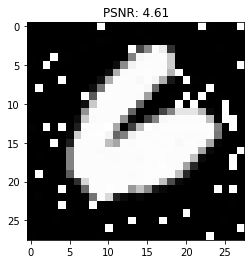

PSNR for image 82: 361.20199909921956


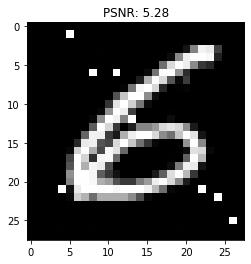

PSNR for image 83: 361.20199909921956


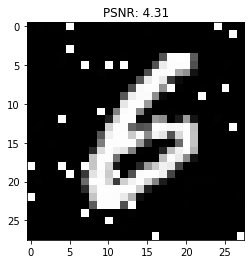

PSNR for image 84: 361.20199909921956


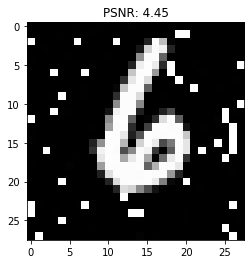

PSNR for image 85: 361.20199909921956


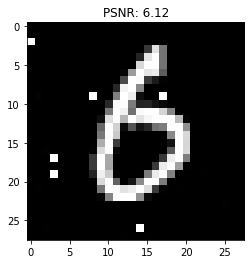

PSNR for image 86: 361.20199909921956


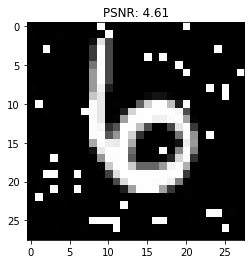

PSNR for image 87: 361.20199909921956


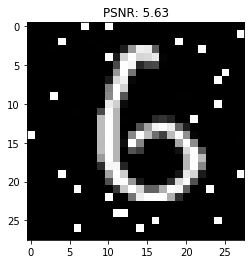

PSNR for image 88: 361.20199909921956


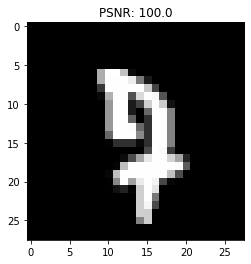

PSNR for image 89: 361.20199909921956


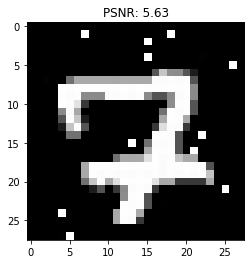

PSNR for image 90: 361.20199909921956


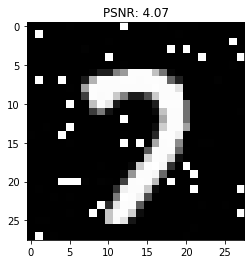

PSNR for image 91: 361.20199909921956


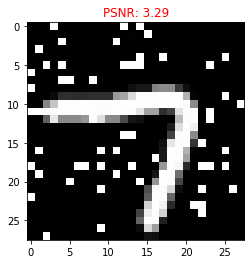

PSNR for image 92: 361.20199909921956


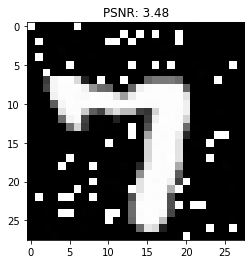

PSNR for image 93: 361.20199909921956


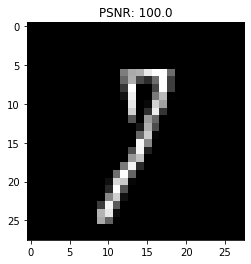

PSNR for image 94: 361.20199909921956


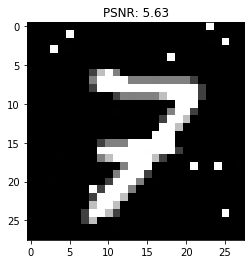

PSNR for image 95: 361.20199909921956


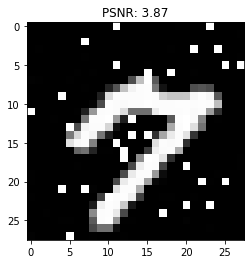

PSNR for image 96: 361.20199909921956


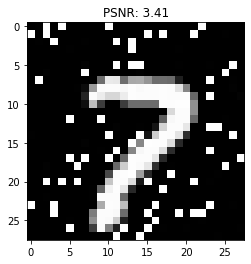

PSNR for image 97: 361.20199909921956


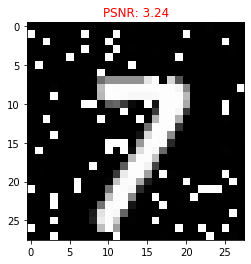

PSNR for image 98: 361.20199909921956


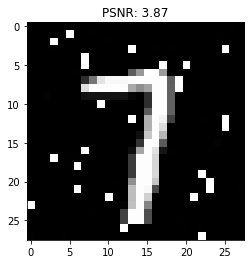

PSNR for image 99: 361.20199909921956


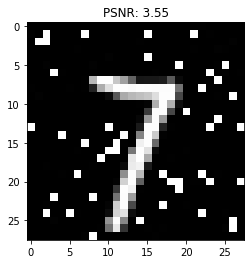

PSNR for image 100: 361.20199909921956


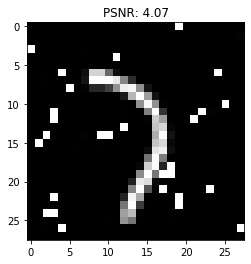

PSNR for image 101: 361.20199909921956


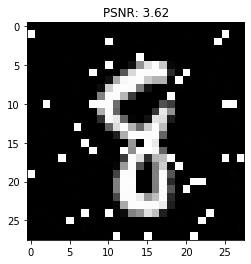

PSNR for image 102: 361.20199909921956


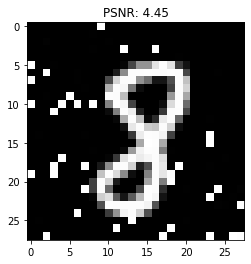

PSNR for image 103: 361.20199909921956


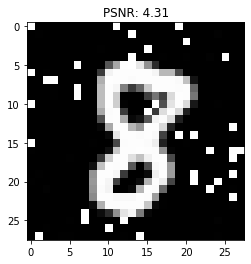

PSNR for image 104: 361.20199909921956


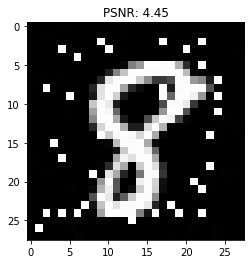

PSNR for image 105: 361.20199909921956


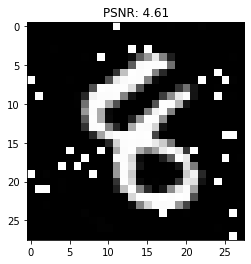

PSNR for image 106: 361.20199909921956


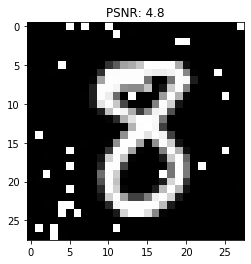

PSNR for image 107: 361.20199909921956


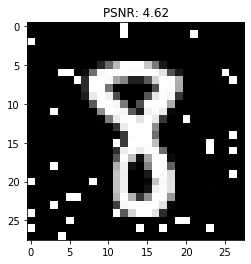

PSNR for image 108: 361.20199909921956


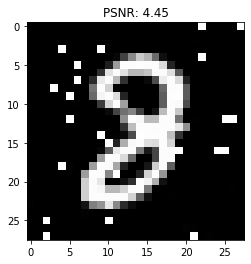

PSNR for image 109: 361.20199909921956


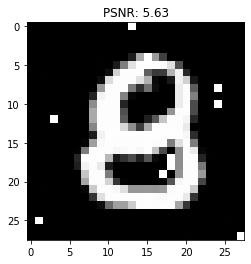

PSNR for image 110: 361.20199909921956


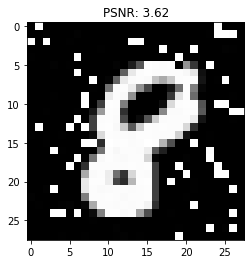

PSNR for image 111: 361.20199909921956


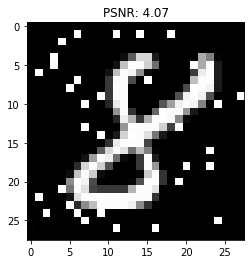

PSNR for image 112: 361.20199909921956


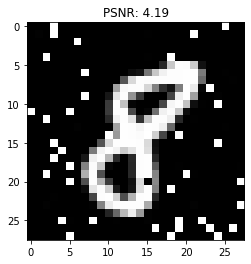

PSNR for image 113: 361.20199909921956


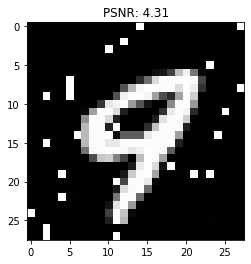

PSNR for image 114: 361.20199909921956


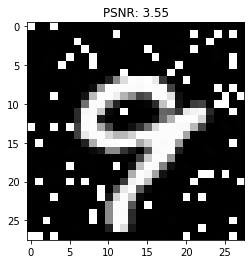

PSNR for image 115: 361.20199909921956


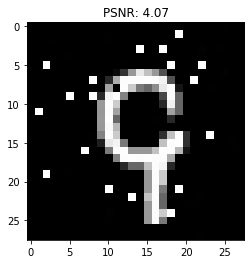

PSNR for image 116: 361.20199909921956


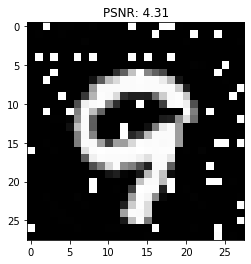

PSNR for image 117: 361.20199909921956


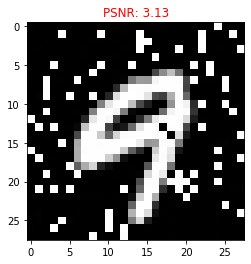

PSNR for image 118: 361.20199909921956


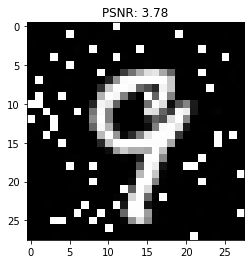

PSNR for image 119: 361.20199909921956


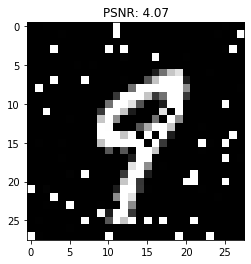

PSNR for image 120: 361.20199909921956


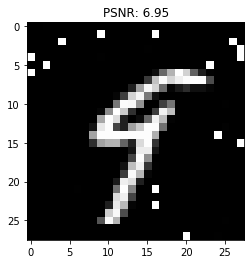

PSNR for image 121: 361.20199909921956


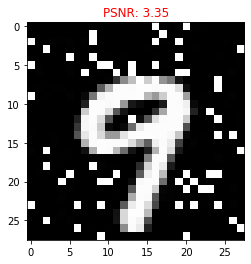

PSNR for image 122: 361.20199909921956


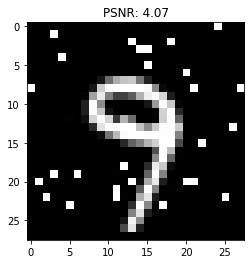

PSNR for image 123: 361.20199909921956


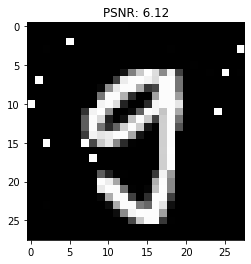

PSNR for image 124: 361.20199909921956


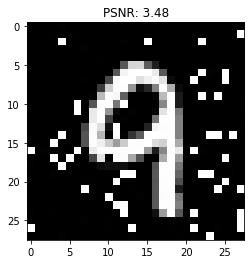

PSNR for image 125: 361.20199909921956


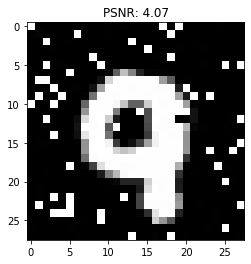

111


In [13]:
psnrs_cnn = []
for i in range(len(adversarials)):
    psnrs_cnn.append(cv2.PSNR(adversarial[i].reshape(28,28)[5:-5,5:-5], adversarials[i].reshape(28,28)[5:-5,5:-5]))

above_tresh = 0
threshold_psnr = 3.4
for i in range(len(adversarials)):
    psnr_ = cv2.PSNR(adversarial[i].reshape(28,28),adversarial[i].reshape(28,28))
    psnr_cnn = round((psnrs_cnn[i]/psnr_)*100,2)
    print("PSNR for image " + str(i) + ": " + str(psnr_))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    ax1.imshow(adversarials[i].reshape(28,28),cmap="gray")
    if psnr_cnn < threshold_psnr:
        ax1.set_title("PSNR: "+str(psnr_cnn), color='red')
    else: 
        ax1.set_title("PSNR: "+str(psnr_cnn))
        above_tresh += 1
    plt.show()
print(above_tresh)

In [14]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))
print(np.mean(times),'+-', np.std(times),'(',np.min(times),',',np.max(times),')')

166.265625
0.453125
5.5240575396825395
16.68838749827473
5.5240575396825395 +- 16.68838749827473 ( 0.453125 , 166.265625 )


In [15]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))
print(np.mean(nfes),'+-', np.std(nfes),'(',np.min(nfes),',',np.max(nfes),')')

260
0
7.571428571428571
26.168692239291193
7.571428571428571 +- 26.168692239291193 ( 0 , 260 )


In [16]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))
print(np.mean(psnrs),'+-', np.std(psnrs),'(',np.min(psnrs),',',np.max(psnrs),')')

361.20199909921956
4.799073446052787
41.054383267698825
94.03723022606988
41.054383267698825 +- 94.03723022606988 ( 4.799073446052787 , 361.20199909921956 )


In [17]:
print(np.max(ssim_scores))
print(np.min(ssim_scores))
print(np.mean(ssim_scores))
print(np.std(ssim_scores))
print(np.mean(ssim_scores),'+-', np.std(ssim_scores),'(',np.min(ssim_scores),',',np.max(ssim_scores),')')

1.0
0.21281793102099014
0.6327221511507977
0.17608515426232463
0.6327221511507977 +- 0.17608515426232463 ( 0.21281793102099014 , 1.0 )
